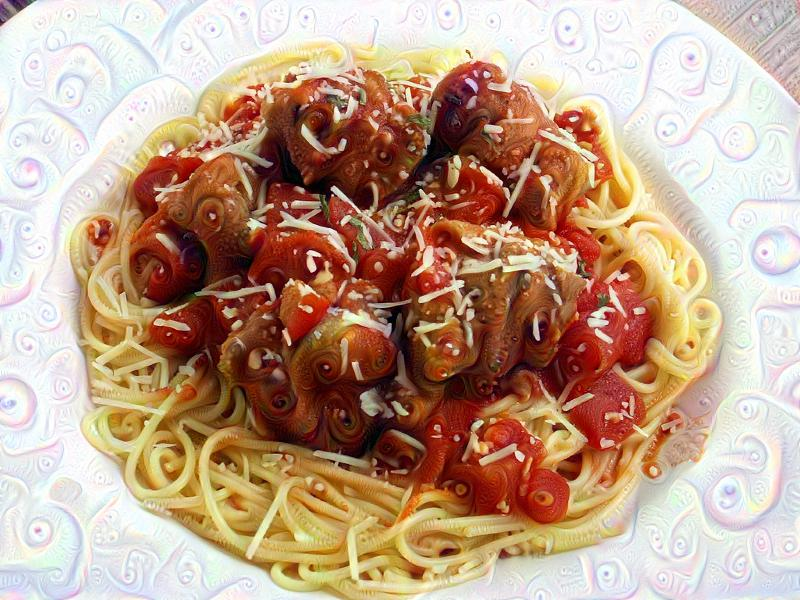

10 4 inception_3b/pool (600, 800, 3)


In [4]:
from __future__ import division
from io import BytesIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import cv2
import caffe

# uncomment for GPU acceleration
# caffe.set_mode_gpu()
# caffe.set_device(0)

#showimages = True

try:
    # Python 2
    xrange
except NameError:
    # Python 3, xrange is now named range
    xrange = range

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


#model_path = '~/Documents/beuth_lectures/LFI_Projekt_ws2019/tests/deepdream/tutdeep/models/'  # substitute your path here
net_fn = './models/bvlc_googlenet/deploy.prototxt'
param_fn = './models/bvlc_googlenet/bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
    
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn, mean=np.float32([104.0, 116.0, 122.0]),channel_swap=(2, 1, 0))

# utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']


def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])


def objective_L2(dst):
    dst.diff[:] = dst.data


def make_step(net, step_size=1.0, end='inception_3b/5x5_reduce',
                  jitter=32, clip=True):
    '''Basic gradient ascent step'''

    src = net.blobs['data']  # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter + 1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2)  # apply jitter shift

    net.forward(end=end)
    objective_guide(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size / np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2)  # unshift image

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255 - bias)

def deepdream(net, base_img, iter_n=5, octave_n=11, octave_scale=1.4, end='inception_3b/5x5_reduce', clip=True,
              **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1])  # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0 * h / h1, 1.0 * w / w1), order=1)

        src.reshape(1, 3, h, w)  # resize the network's input image size
        src.data[0] = octave_base + detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)

            # visualization
            vis = deprocess(net, src.data[0])
            if not clip:  # adjust image contrast if clipping is disabled
                vis = vis * (255.0 / np.percentile(vis, 99.98))
            showarray(vis)
            print(octave, i, end, vis.shape)
            clear_output(wait=True)

        # extract details produced on the current octave
        detail = src.data[0] - octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])


img = np.float32(PIL.Image.open('./spagetti.png'))
print(img.shape)
showarray(img,'png')

guide = np.float32(PIL.Image.open('./biostyle.png'))
end = 'inception_3b/pool'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y)    # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)]   # select ones that match best

frame = deepdream(net, img, end=end)   # can specify different convolutional/pooling layer with `end` argument here
PIL.Image.fromarray(np.uint8(frame)).save("result.jpg")

In [5]:
!mkdir frames
frame = img
frame_i = 0

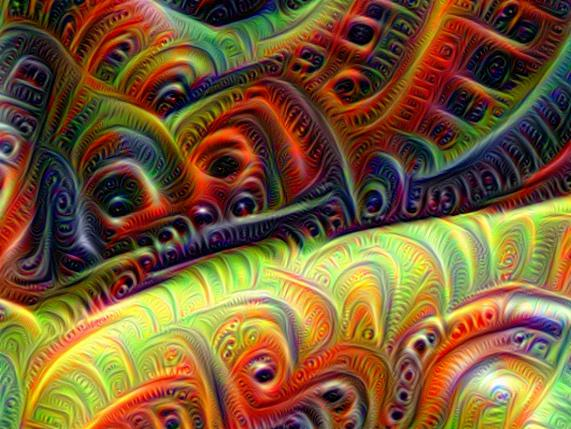

9 2 inception_3b/5x5_reduce (429, 571, 3)


In [ ]:
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1